In [1]:
import numpy as np
import math as math
from qiskit.quantum_info.operators.pauli import Pauli
from qiskit.aqua.operator import Operator
from qiskit.aqua.algorithms import ExactEigensolver
from qiskit.aqua.algorithms.classical.cplex.cplex_ising import CPLEX_Ising
from collections import OrderedDict
import matplotlib.pyplot as plt 
import networkx as nx

from IPython.display import display, HTML
display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
"""))

C:\Users\javig\Anaconda3\envs\Qiskit\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


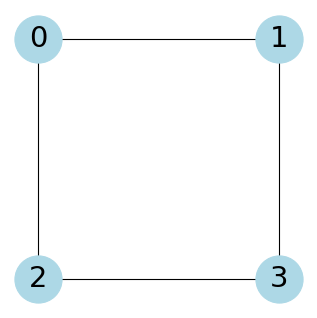

In [2]:
N_col = 2 #Nodes per row
N_row = 2 #Nodes por column

G=nx.grid_2d_graph(N_col, N_row, periodic=True)

pos = dict(zip(G.nodes(),G.nodes()))
ordering = [(x,N_row-1-y) for y in range(N_row) for x in range(N_col)]  

labels = dict(zip(ordering, range(len(ordering))))   

fig = plt.figure(figsize=(5, 5), dpi= 80, facecolor='w', edgecolor='k', constrained_layout = False)

nx.draw_networkx(G, pos=pos, with_labels=False, node_size = 1800, node_color='lightblue')                                                                       
nx.draw_networkx_labels(G, pos=pos, labels=labels, font_size=26)                              
plt.axis('off')     
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

In [3]:
A = nx.to_numpy_matrix(G, nodelist=ordering)
print(A)
J = -1*np.ones(np.shape(A))
np.fill_diagonal(J, 0)
J = np.triu(J)

h = 3*np.ones(len(A))

[[0. 1. 1. 0.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [0. 1. 1. 0.]]


#### 1. Brute-froce method
This method does not require a Hamiltonian and it basically consists in exhaustively try all the binary assignments. In each binary assignment, the entry of a subset is either 0 (meaning the subset is not in the cover) or 1 (meaning the subset is in the cover). We print the binary assignment that satisfies the definition of the exact cover.

In [4]:
def brute_force(weight_matrix, J, h):
    # brute-force way: try every possible assignment!

    #First define a function which transforms a integer to a list whose elements are the binary digits of the number
    def bitfield(n, L):
        result = np.binary_repr(n, L)
        return np.array([int(digit) for digit in result])  # [2:] to chop off the "0b" part

    L = np.shape(weight_matrix)[0]
    max = 2**L
    #Try every possible combination and check if it is an exact cover

    def energy(sigma, weight_matrix, J, h):
        interaction = -((sigma@(np.multiply(weight_matrix, J)))@sigma).item(0)
        field = - h@sigma
        E = interaction + field 
        return E
    
    Ener = []
    sol = []
    for i in range(max):
        sig = bitfield(i, L)
        sig = sig - (sig==0)
        E = energy(sig, weight_matrix, J, h)
        Ener.append(E)
        sol.append(list(sig + (sig==-1)))
        
    Ener, sol = (list(t) for t in zip(*sorted(zip(Ener, sol))))
    Ener = np.array(Ener)
    sol = np.array([np.array(sol[i]) for i in range(len(sol))])
    
    return sol, Ener

sol, ener = brute_force(A, J, h)

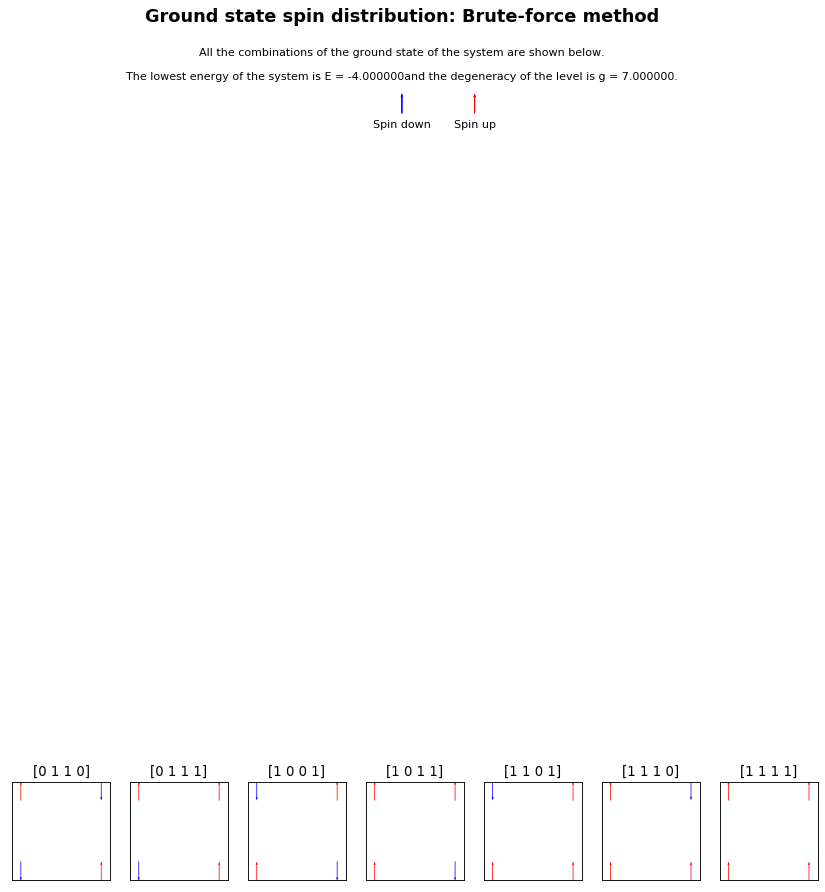

In [16]:
def ising_map(N_col, N_row, sol, ener=0, titulo='', deg = True):
    
    if (type(ener) == int) or (len(ener)==1):
        long = 1
    else:
        long = len(sol[ener==ener[0]])
    
    m = (math.ceil(long/3))/2
    
    fig = plt.figure(figsize=(13, 15*m), dpi= 80, facecolor='w', edgecolor='k')
    fig.subplots_adjust(top = 1-0.1/m, hspace=-0.2, wspace=0.2)
    
    xx = np.linspace(1,10, N_col)
    yy = np.linspace(1,10, N_row)
    
    (X,Y) = np.meshgrid(xx,yy)
    u =np.zeros(np.shape(X))
    
    colormap = plt.cm.bwr

    for i in range(0, long):
        if (type(ener) == int) or (len(ener)==1):
            isol = sol
        else:
            isol = sol[i]
            
        v = isol - (isol==0)
        v = v.reshape(np.shape(Y))
        c = isol*1.
        
        ax = fig.add_subplot(math.ceil(long/7), 7, i+1)
            
        ax.set_title(isol)
        
        q = plt.quiver(X,Y,u,v, color=colormap(c), angles='xy',scale=5, pivot = 'middle')
        
        if i == 0:
            p = plt.quiverkey(q, 0.57, 1-0.1/m, 1,"Spin up",coordinates='figure',color='r', angle = 90, labelpos='S', labelsep=0.2)
            p = plt.quiverkey(q, 0.5, 1-0.1/m, 1,"Spin down",coordinates='figure',color='b', angle = 90, labelpos='S', labelsep=0.2)
        plt.xlim(0, 11)
        plt.ylim(0, 11)

        plt.gca().set_aspect('equal', adjustable='box')
        #plt.axis('off') 
        
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        plt.xticks([])
        plt.yticks([])
        plt.gca().set_aspect('equal', adjustable='box')

    
    fig.suptitle('Ground state spin distribution: '+titulo, fontsize = 16, fontweight= 'bold', y= 1-0.3/(15*m))
    #plt.savefig('Error map km', bbox_inches = 'tight', pad_inches = 0.1)
    
    txt = 'All the combinations of the ground state of the system are shown below.' 
    fig.text(0.5, 1-0.9/(15*m), txt, ha='center')    
    try:
        txt2 = 'The lowest energy of the system is E = %f' % ener[0]
        txt3 = 'and the degeneracy of the level is g = %f.' % long
        
        if deg == True:
            txt4 = txt2+txt3
        else:
            txt4 = txt2
        fig.text(0.5, 1-1.2/(15*m), txt4, ha='center')
        #fig.text(0.5, 0.15, txt2, ha='center')

    except:
        pass
    plt.savefig('brute_33.png')
    plt.show()

ising_map(N_col, N_row, sol, ener, titulo='Brute-force method')

Note that for small graphs (smaller or equal than 3x3) border conditions take relevance resulting in a big degeneration, while for bigger scales border effect can be neglected.

#### 2. Classical way

In [6]:
class ising:
    def __init__(self):
        self.mu_0 = 1
    
    def get_ising_qubitops(self,weight_matrix, J, h):
        """
        Generate Hamiltonian for the ising model.

        Args:
            weight_matrix (numpy.ndarray) : adjacency matrix, J: interaction matrix, h: field array.

        Returns:
            operator.Operator, float: operator for the Hamiltonian and a
            constant shift for the obj function.
        """    
        num_nodes = weight_matrix.shape[0]
        pauli_list = []
        shift = 0
    
        for j in range(num_nodes):
            for i in range(j):
                if (weight_matrix[i,j] != 0):
                    wp = np.zeros(num_nodes)
                    vp = np.zeros(num_nodes)
                    vp[i] = 1
                    vp[j] = 1
                    pauli_list.append([-J[i, j], Pauli(vp, wp)])
                    #shift -= J * weight_matrix[i, j]
            up = np.zeros(num_nodes)
            wp = np.zeros(num_nodes)
            up[j] = 1
            pauli_list.append([-h[j]*self.mu_0, Pauli(up, wp)])        
        
        return Operator(paulis=pauli_list), shift

    def sample_most_likely(self, state_vector):
        """Compute the most likely binary string from state vector.
        Args:
            state_vector (numpy.ndarray or dict): state vector or counts.
        Returns:
            numpy.ndarray: binary string as numpy.ndarray of ints.
        """
        if isinstance(state_vector, dict) or isinstance(state_vector, OrderedDict):
        # get the binary string with the largest count
            binary_string = sorted(state_vector.items(), key=lambda kv: kv[1])[-1][0]
            x = np.asarray([int(y) for y in reversed(list(binary_string))])
            return x
        else:
            n = int(np.log2(state_vector.shape[0]))
            k = np.argmax(np.abs(state_vector))
            u = np.binary_repr(k, width=n)
            x = np.array([ int(u[j]) for j in range(n)])
            return x

    
    def get_solution(self, x):
        """Compute the most likely binary string from state vector.
        Args:
            state_vector (numpy.ndarray or dict): state vector or counts.
        Returns:
            numpy.ndarray: binary string as numpy.ndarray of ints.
        """
        x = np.array([1 - x[i] for i in range(len(x))])
        return x

In [7]:
ising = ising()
qubitOp, offset = ising.get_ising_qubitops(A, J, h)

#algo = ExactEigensolver(qubitOp, k=2**(N_col*N_row), aux_operators=[])
#result = algo.run()

#x = [ ising.sample_most_likely(result['eigvecs'][i]) for i in range(len(result['eigvecs'])) ]
#ising_sol = ising.get_solution(x)
#print(len(result['eigvecs']))
#ising_map(N_col, N_row, ising_sol, result['eigvals'], titulo='Algebra classical method')

C:\Users\javig\Anaconda3\envs\Qiskit\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


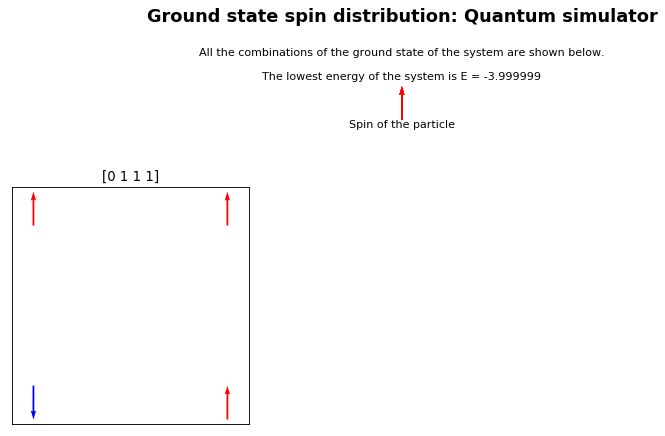

Solution is [0 1 1 1]
Time (s): 9.862217426300049
Energy (J): -3.9999994176880955
Number of evaluations: 350


In [8]:
from qiskit import Aer
from qiskit.aqua import run_algorithm
from qiskit.aqua.input import EnergyInput

algo_input = EnergyInput(qubitOp)

#The Variational-Quantum-Eigensolver (VQE) algorithm is selected

algorithm_cfg = {
    'name': 'VQE',
    'operator_mode': 'paulis'
}

#Constrained optimization by linear approximation (COBYLA) is a numerical optimization method for constrained problems 
#where the derivative of the objective function is not known.
#https://en.wikipedia.org/wiki/COBYLA

optimizer_cfg = {
    'name': 'JAVI',
}

#The RyRz trial wave function is layers of y plus z rotations with entanglements.
#https://qiskit.org/documentation/aqua/variational_forms.html

var_form_cfg = {
    'name': 'RY',
    'depth': 3,
    'entanglement' : "linear"
}

initial_states = {
    'name': 'ZERO'
}

#Now the params are defined
params = {
    'problem': {'name': 'ising', 'random_seed': 10598},
    'algorithm': algorithm_cfg,
    'optimizer': optimizer_cfg,
    'variational_form': var_form_cfg,
    'initial_state': initial_states
}

#Finally we use the 'statevector_simulator' backend to simulate
backend = Aer.get_backend('statevector_simulator')

result = run_algorithm(params, algo_input, backend=backend)

x = ising.sample_most_likely(result['eigvecs'][0])

ising_sol = ising.get_solution(x)

ising_map(N_col, N_row, ising_sol, result['eigvals'], titulo='Quantum simulator', deg = False)

print("Solution is", ising_sol)
print('Time (s):', result['eval_time'])
print('Energy (J):', result['energy'] + offset)
print('Number of evaluations:', result['eval_count'])

Uno puede pensar que la función de onda final será una combinación de todas las posibles soluciones. Sin embargo, esto no es así pues los optimizadores se encargan de buscar una única solución. Encontrarlas todas supone un problema que se encuentra fuera de NP-hard, está en PSPACE (creo, según juanjo).

In [9]:
print('The energy expected for the ground state is %f J (¿son julios realmente?) and the energy of the final state is %f J.' % (ener[0], result['eigvals']))
print('This means that there is a relative error in the energy of the ground state of %.2e J, due to the noise registered by the population of other states.' % (abs(ener[0]-result['eigvals'])/abs(ener[0])))

The energy expected for the ground state is -4.000000 J (¿son julios realmente?) and the energy of the final state is -3.999999 J.
This means that there is a relative error in the energy of the ground state of 1.46e-07 J, due to the noise registered by the population of other states.


## Bibliography

**[1]** Pathria, R. K., & Beale, P. D. Statistical mechanics. 2011.

**[2]** Arovas, D. (2013). Lecture notes on thermodynamics and statistical mechanics.

**[3]** MIT OpenCourseWare. (2014, April). Transfer Matrices & Position space renormalization. Retrieved February 15, 2019.

https://github.com/Qiskit/qiskit-aqua/blob/7e39e4cff5f69c1b0d8e55532df45e0b1bd72c81/qiskit_acqua/ising/maxcut.py

https://en.wikipedia.org/wiki/Square-lattice_Ising_model